In [1]:
import numpy as np
import tifffile
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import cv2
from scipy.interpolate import RegularGridInterpolator
import pickle
from skimage.feature import peak_local_max
from datetime import datetime

In [2]:
image = tifffile.imread(r"Z:\2_Data\LWJ\RUSH3D\Data\White\20240522\White_panorama_20X_C2\capture\C2\White_panorama_20X_S1_C2_9.tiff")
image.shape
# image = image[0]
H,W=image.shape
centerX = W//2
centerY = H//2-1
H,W,centerX,centerY

(10748, 14304, 7152, 5373)

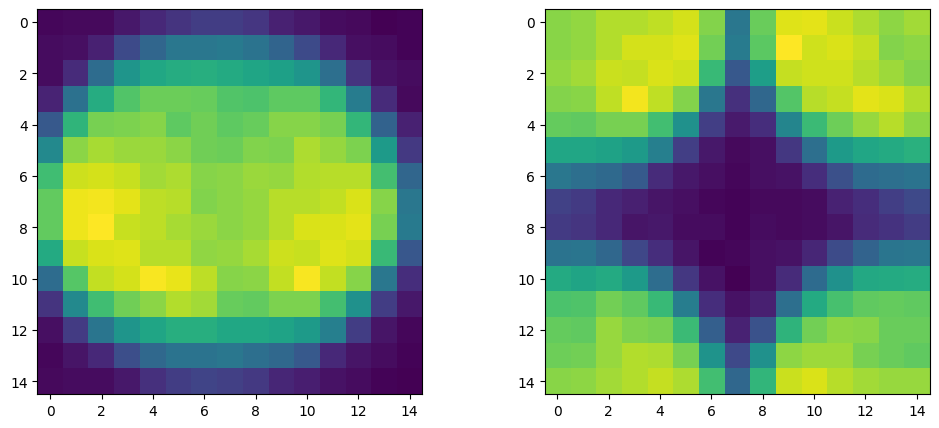

In [3]:
center=image[centerY-7:centerY+8,centerX-7:centerX+8]
center15=image[centerY:centerY+15,centerX:centerX+15]
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
ax[0].imshow(center)
ax[1].imshow(center15)

In [4]:
gt=np.zeros_like(image)

for i in range(centerY%15,gt.shape[0],15):
    for j in range(centerX%15,gt.shape[1],15):
        center_coordinates = j,i
        radius = 6
        color = 10000
        thickness = cv2.FILLED
        cv2.circle(gt, center_coordinates, radius, color, thickness)
tifffile.imwrite("./gt.tif",gt.astype(np.uint16))

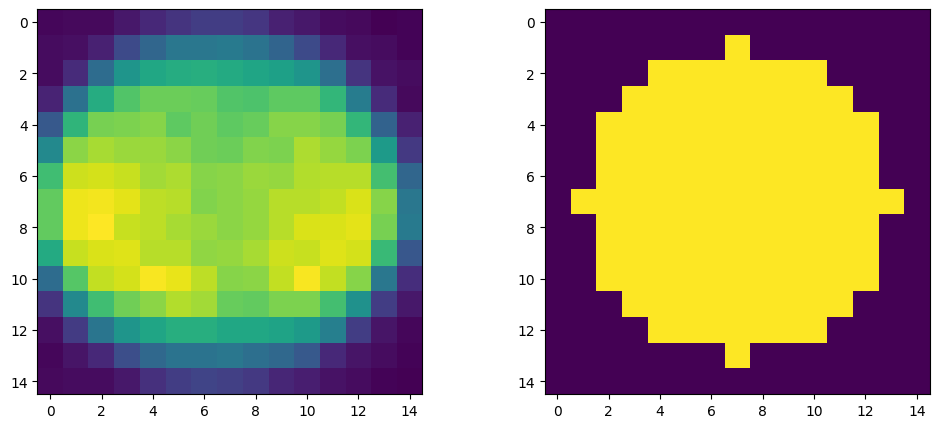

In [5]:
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
ax[0].imshow(center)
ax[1].imshow(gt[centerY-7:centerY+8,centerX-7:centerX+8])

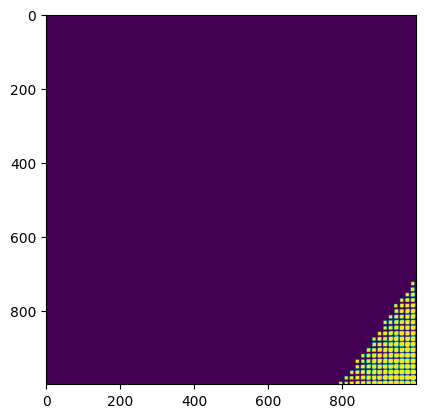

In [6]:
def adaptive_threshold(IM, ws, C):
    # 将输入图像归一化到0-1之间
    IM = cv2.normalize(IM, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # 使用均值滤波器对图像进行滤波
    mean_IM = cv2.blur(IM, (ws, ws))
    # 对原图像和滤波后的图像做差，然后再减去常数C
    substract = IM - mean_IM*0.5- C
    # 将上一步计算出的图像进行二值化处理
    _, bw = cv2.threshold(substract, 0, 1, cv2.THRESH_BINARY)
    return bw

# 应用自适应阈值二值化
gray=image.copy()
bw = adaptive_threshold(gray, 15, 0.01)
# fig,ax=plt.subplots(ncols=2,figsize=(12,5))
# ax[0].imshow(gray[:1000,:1000])
# ax[1].imshow((bw[:1000,:1000]*65535).astype(np.uint16))
tifffile.imwrite('bw.tif',bw.astype(np.uint16))
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(bw, cv2.MORPH_OPEN, kernel, iterations = 4)
plt.imshow(opening[:1000,:1000])
tifffile.imwrite('opening.tif',opening.astype(np.uint16))

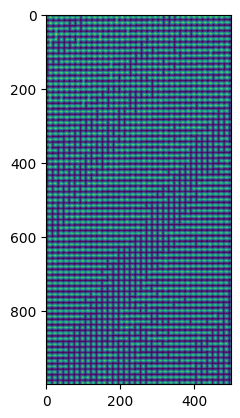

In [7]:
dist_transform = cv2.distanceTransform(opening.astype(np.uint8), cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
plt.imshow(dist_transform[1000:2000,1500:2000])
tifffile.imwrite('dist_transform.tif',dist_transform.astype(np.uint16))

In [8]:
dist_coor = peak_local_max(dist_transform, min_distance=12) 

In [9]:
a=image.copy()
a[dist_coor[:,0],dist_coor[:,1]]=0
tifffile.imwrite('white_with_dist_pos.tif',a)

In [10]:
# The distort_model function applies distortion to a set of x and y coordinates based on the provided distortion parameters.
def distort_model(params, x,y):
    fx,fy,cx,cy,k1, k2, k3, p1, p2 = params
    matrix=np.array([[fx,0,cx],[0,fy,cy],[0,0,1]])
    objpoints=np.concatenate((x[:,np.newaxis],y[:,np.newaxis],np.ones_like(y[:,np.newaxis])),axis=1)
    objpoints_rotated=np.matmul(objpoints, matrix)
    objpoints_projected = objpoints_rotated[:, :2] / (objpoints_rotated[:, 2:] + 1e-17)
    shift=objpoints_projected-np.array([cx,cy])

    x_shifted = shift[:,0]
    y_shifted = shift[:,1]
    r2 = x_shifted**2 + y_shifted**2
    x_distorted = x_shifted * (1 + k1*r2 + k2*r2**2 + k3*r2**3) + 2*p1*x_shifted*y_shifted + p2*(r2 + 2*x_shifted**2) + cx
    y_distorted = y_shifted * (1 + k1*r2 + k2*r2**2 + k3*r2**3) + p1*(r2 + 2*y_shifted**2) + 2*p2*x_shifted*y_shifted + cy
    return x_distorted, y_distorted


# The error_function calculates the difference between the predicted and actual values of x and y.
def error_function(params, x, y, mapx, mapy):
    x_predicted, y_predicted = distort_model(params, x, y)
    return np.concatenate((x_predicted - mapx, y_predicted - mapy))

# The generate_params function generates distortion and undistortion parameters using a least squares optimization process.
def generate_params(x_distorted, y_distorted, x_ideal, y_ideal):
    params_initial = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    result_undist = least_squares(error_function, params_initial, args=(x_distorted, y_distorted, x_ideal, y_ideal))
    result_dist = least_squares(error_function, params_initial, args=( x_ideal, y_ideal,x_distorted, y_distorted))

    return {"undistort":result_undist.x,"inv_undistort":result_dist.x}

In [11]:
## 重校正（使用预模型去畸变后，向真值圆心坐标逼近，获得新的映射关系）
def range_cal(num,base):
    unit = 15
    num_zero_based = num - base
    # Calculate the range
    range_start_zero_based = (num_zero_based // unit) * unit
    range_end_zero_based = range_start_zero_based + unit
    # Calculate the distance to the start and end of the range
    distance_to_start = num_zero_based - range_start_zero_based
    distance_to_end = range_end_zero_based - num_zero_based
    # Determine the closest endpoint (add 1 to convert it back to a range starting from 1)
    closest_endpoint =np.where( distance_to_start < distance_to_end,range_start_zero_based , range_end_zero_based) + base
    return closest_endpoint
    
with open("./undistort_params_dict_points_240527.pkl",'rb') as file:
    params=pickle.load(file)
# 正向过程（去畸变过程）：白图像圆心坐标(grid)-> 对应的去畸变后不规则坐标值（float）
x_distorted = (dist_coor[:,1]-centerX)/100
y_distorted = (dist_coor[:,0]-centerY)/100
x_undistorted, y_undistorted = distort_model(params['undistort'],x_distorted,y_distorted)
x_undistorted_loc=x_undistorted*100+centerX
y_undistorted_loc=y_undistorted*100+centerY
# 去畸变后不规则坐标值（float）向标准圆心位置靠近
x_closest_endpoint=range_cal(x_undistorted_loc,12)
y_closest_endpoint=range_cal(y_undistorted_loc,18)
new_map_xy=np.concatenate((y_closest_endpoint[:,np.newaxis],x_closest_endpoint[:,np.newaxis]),axis=1).astype(np.float32)

In [12]:
a=gt.copy()
a[new_map_xy[:,0].astype(int),new_map_xy[:,1].astype(int)]=0
tifffile.imwrite('gt_with_undist_pos.tif',a)

In [13]:
# 反向过程（畸变过程）：规则的去畸变图像坐标(grid)-> 畸变后对应的不规则坐标值（float）
def undistort_coor(params):
    H, W = (10748,14304)
    gty,gtx = np.mgrid[:H, :W]
    gtxy = np.c_[gtx.ravel(), gty.ravel()]
    x_undistorted, y_undistorted = distort_model(params['inv_undistort'],(gtxy[:,0]-W//2)/100,(gtxy[:,1]-H//2)/100)
    x_undistorted=x_undistorted*100+W//2
    y_undistorted=y_undistorted*100+H//2
    return x_undistorted,y_undistorted

# 使用插值方法找到上述不规则坐标对应的像素值
def single_interpolate(image,x_undistorted,y_undistorted):
    centerB =image.copy()
    # desX=14000
    # desY=10000
    # sideX = (sx-desX)//2
    # sideY = (sy-desY)//2
    y = np.linspace(0, centerB.shape[0]-1, centerB.shape[0])
    x = np.linspace(0, centerB.shape[1]-1, centerB.shape[1])

    Ti = RegularGridInterpolator((y, x), centerB, method="linear", fill_value = 0)
    aa = Ti(np.stack([np.clip(y_undistorted,0,centerB.shape[0]-1), np.clip(x_undistorted,0,centerB.shape[1]-1)]).T)
    bb = aa.reshape(centerB.shape)
    return bb.astype(np.uint16)


In [14]:
x_ideal = (new_map_xy[:,1]-centerX)/100
y_ideal = (new_map_xy[:,0]-centerY)/100

x_distorted = (dist_coor[:,1]-centerX)/100
y_distorted = (dist_coor[:,0]-centerY)/100

params_new=generate_params(x_distorted,y_distorted,x_ideal,y_ideal)

In [17]:
with open("./undistort_params_dict_points_240527.pkl",'rb') as file:
    params=pickle.load(file)
# 反向过程（畸变过程）：规则的去畸变图像坐标(grid)-> 畸变后对应的不规则坐标值（float）
x_undistorted,y_undistorted = undistort_coor(params_new) 
# 使用插值方法找到上述不规则坐标对应的像素值
image_undistort = single_interpolate(image,x_undistorted,y_undistorted)  
tifffile.imwrite("image_undistort.tif",image_undistort.astype(np.uint16)) 

In [80]:
crop_H, crop_W = 10005, 14025
image_undistort_crop = image_undistort[centerY-crop_H//2:centerY+crop_H//2+1,centerX-crop_W//2:centerX+crop_W//2+1]
wigner = image_undistort_crop.reshape(667,15,935,15).transpose(1,3,0,2).reshape(225,667,935)
tifffile.imwrite("wigner.tif",wigner.astype(np.uint16)) 

In [16]:
with open("undistort_params_dict_"+datetime.now().strftime("%y%m%d")+".pkl",'wb') as f:
    pickle.dump(params_new,f)